In [12]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from util import util
import os
import numpy as np
from tensorflow.keras import callbacks
import warnings
warnings.simplefilter("ignore")

# Load data
data_folder = os.path.join('..', 'data')
data = util.load_data(data_folder)

# Identify input columns
dt_in = list(data.columns[3:-1]) # Exclude metadata

# Focus on a subset of the data
data_by_src = util.split_by_field(data, field='src')
dt = data_by_src['train_FD004']

# Split training and test machines
tr_ratio = 0.75
np.random.seed(42)
machines = dt.machine.unique()
np.random.shuffle(machines)

sep = int(tr_ratio * len(machines))
tr_mcn = machines[:sep]
ts_mcn = machines[sep:]

tr, ts = util.partition_by_machine(dt, tr_mcn)

# Standardization and normalization
trmean = tr[dt_in].mean()
trstd = tr[dt_in].std().replace(to_replace=0, value=1) # handle static fields
ts_s = ts.copy()
ts_s[dt_in] = (ts_s[dt_in] - trmean) / trstd
tr_s = tr.copy()
tr_s[dt_in] = (tr_s[dt_in] - trmean) / trstd

trmaxrul = tr['rul'].max()
ts_s['rul'] = ts['rul'] / trmaxrul 
tr_s['rul'] = tr['rul'] / trmaxrul 

# Define a cost model
failtimes = dt.groupby('machine')['cycle'].max()
safe_interval = failtimes.min()
maintenance_cost = failtimes.max()
cmodel = util.RULCostModel(maintenance_cost=maintenance_cost, safe_interval=safe_interval)

## Sliding window input
#wlen = 3
#tr_sw, tr_sw_m, tr_sw_r = util.sliding_window_by_machine(tr_s, wlen, dt_in)
#ts_sw, ts_sw_m, ts_sw_r = util.sliding_window_by_machine(ts_s, wlen, dt_in)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# RUL Prediction as Classification

## RUL Prediction as Classification

**RUL-based maintenance can also be tackled _using a classifier_**

* We build a classifier to determine whether a failure will occur in $\theta$ steps
* We stop as soon as the classifier outputs (say) a 0, i.e.

$$
f_\theta(x, \lambda) = 0
$$

* $f$ is the classifier, with parameter vector $\lambda$
* $\theta$ is the horizon for detecting a failure

**In a sense, we are trying to learn _directly_ a maintenance policy**

* The policy is the form "stop $\theta$ units before a failure"
* The classifier tries to learn it

## Classifier Architecture

**We can therefore immediately define our classifier architecture:**

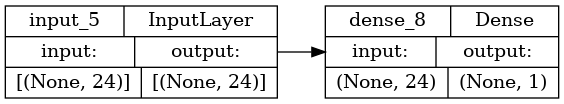

In [13]:
nn1 = util.build_nn_model(input_shape=(len(dt_in), ), output_shape=1, hidden=[], output_activation='sigmoid')
util.plot_nn_model(nn1)

* Like in the regression case, we use a Multilayer Perceptron
* The only difference is the use of a sigmoid activation in the output layer
* For `hidden = []` we get Logistic Regression
* ...Which of course if going to be out first model

## Training

**Before training, we need to define the classes**

In turn, this requires to define the detection horizon $\theta$:

In [14]:
class_thr = 18
tr_lbl = (tr['rul'] >= class_thr)
ts_lbl = (ts['rul'] >= class_thr)

* The class is "1" if a failure is more than $\theta$ steps away
* The class if "0" otherwise

**Classification problems _tend to be easier_ than regression problems**

* On the other hand, learning the whole policy
* ...May be trickier than just estimating the RUL 

## Training

**Let's start by training the simplest possible model**

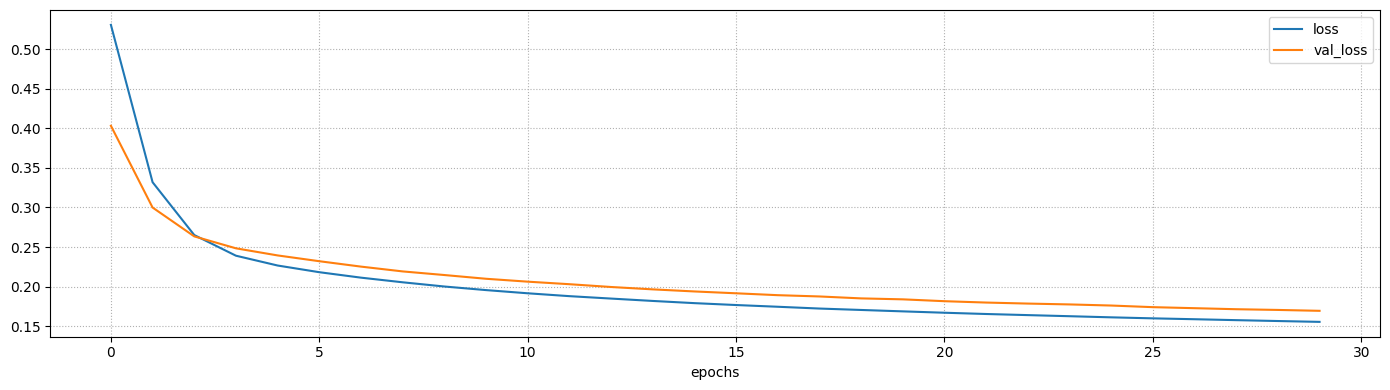

Final loss: 0.1555 (training), 0.1695 (validation)


In [15]:
nn1 = util.build_nn_model(input_shape=(len(dt_in), ), output_shape=1, hidden=[], output_activation='sigmoid')
history = util.train_nn_model(nn1, tr_s[dt_in], tr_lbl, loss='binary_crossentropy', epochs=30,
        verbose=0, patience=10, batch_size=32, validation_split=0.2)
util.plot_training_history(history, figsize=figsize)

## Training

**Then let's try with a deeper model**

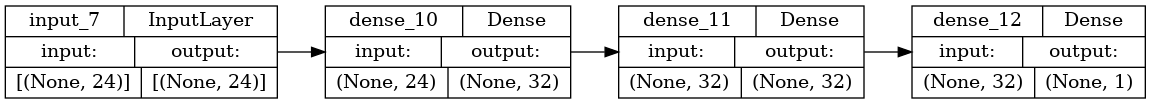

In [16]:
nn2 = util.build_nn_model(input_shape=(len(dt_in), ), output_shape=1, hidden=[32, 32], output_activation='sigmoid')
util.plot_nn_model(nn2)

* Now we have two hidden layers
* ...Each with 32 neurons

## Training

**Let's train it and check the results**

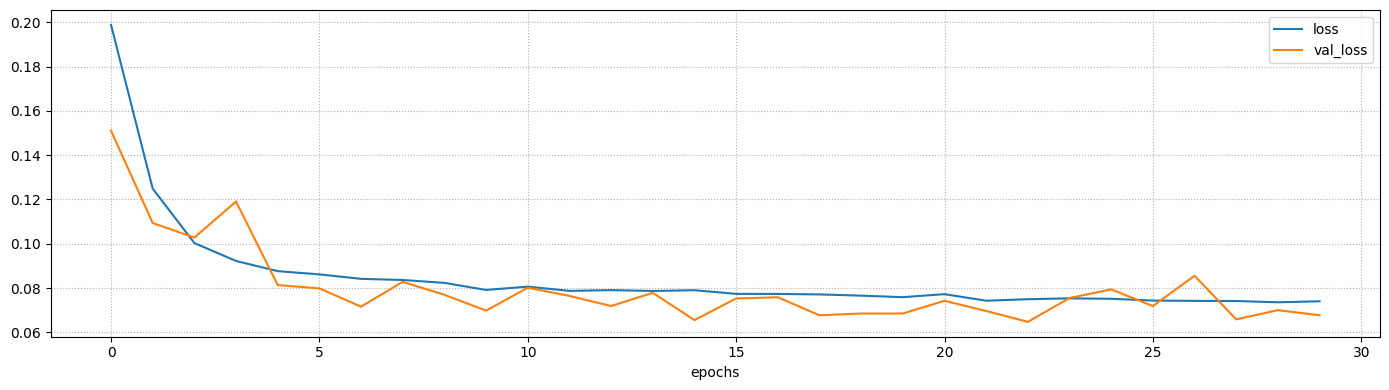

Final loss: 0.0740 (training), 0.0677 (validation)


In [17]:
nn2 = util.build_nn_model(input_shape=(len(dt_in), ), output_shape=1, hidden=[32, 32], output_activation='sigmoid')
history = util.train_nn_model(nn2, tr_s[dt_in], tr_lbl, loss='binary_crossentropy', epochs=30,
        verbose=0, patience=10, batch_size=32, validation_split=0.2)
util.plot_training_history(history, figsize=figsize)

There is a significant improvement over Logistic Regression

## Predictions

**The model prediction can be interpreted as a probabilities of _not_ stopping**

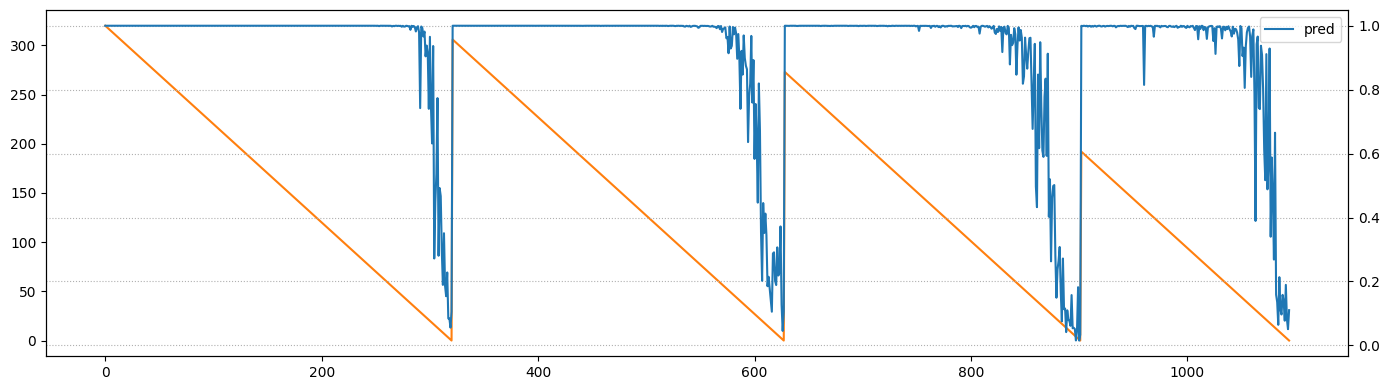

In [25]:
tr_pred2_prob = nn2.predict(tr_s[dt_in], verbose=0).ravel()
stop = 1095
util.plot_rul(tr_pred2_prob[:stop], tr['rul'][:stop], same_scale=False, figsize=figsize)

* The probability falls when closer to failures

## Predictions

**In practice, we'll need to convert the predictions into integers via rounding**

...Unless we want to deal with one more threshold (in addition to $\theta$)

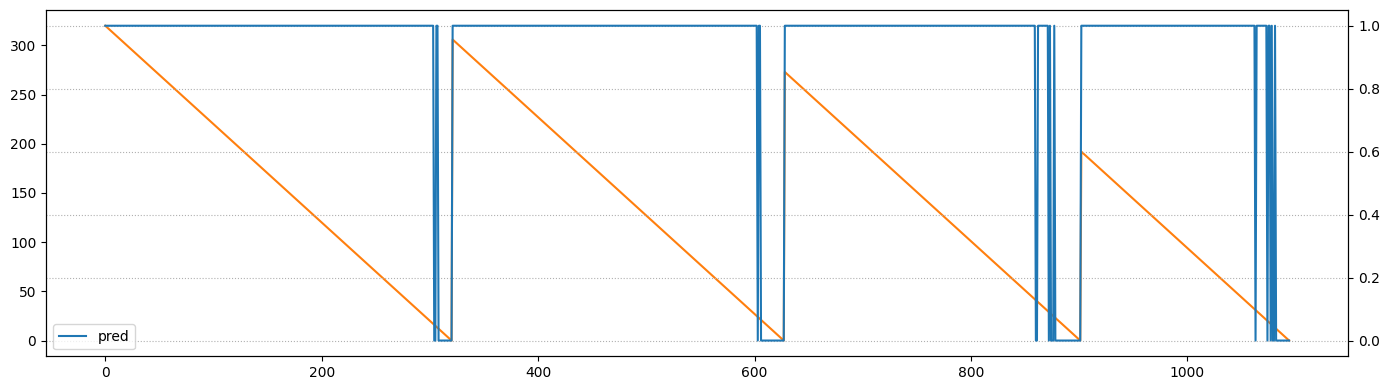

In [26]:
tr_pred2 = np.round(nn2.predict(tr_s[dt_in], verbose=0).ravel())
util.plot_rul(tr_pred2[:stop], tr['rul'][:stop], same_scale=False, figsize=figsize)

* Still, the behavior seems to be reasonable

## Predictions

**Let's see the behavior on the test set**

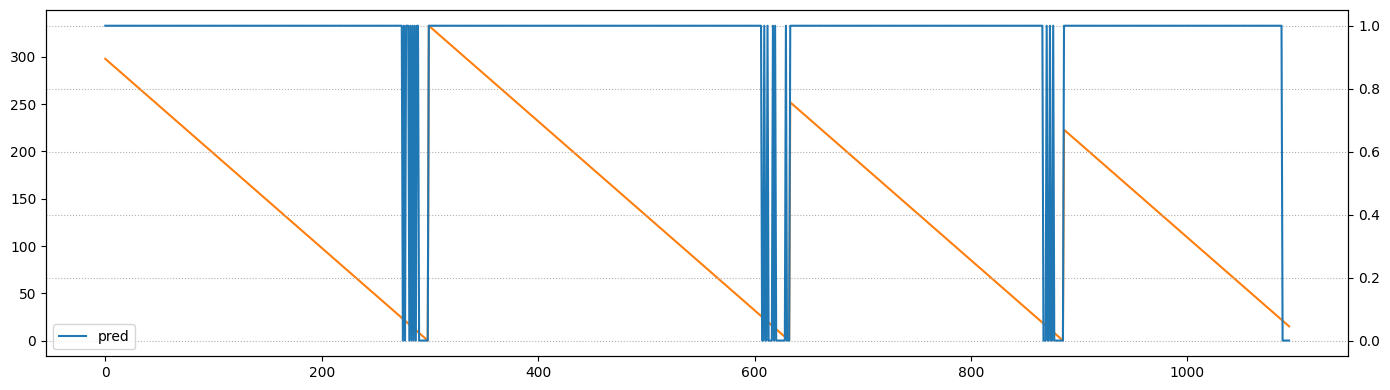

In [27]:
ts_pred2 = np.round(nn2.predict(ts_s[dt_in], verbose=0).ravel())
util.plot_rul(ts_pred2[:stop], ts['rul'][:stop], same_scale=False, figsize=figsize)

* Apparently a decent degree of generalization

## Evaluation

**We can evaluate the classifier directly**

...Because _it defines the whole policy_, with no need for additional calibration!

* On one hand this makes this stage of the process _simpler_
* ...On the other, this is (apparently) a missed opportunity

In [28]:
tr_c2, tr_f2, tr_s2 = cmodel.cost(tr['machine'].values, tr_pred2, 0.5, return_margin=True)
ts_c2, ts_f2, ts_s2 = cmodel.cost(ts['machine'].values, ts_pred2, 0.5, return_margin=True)
print(f'Cost: {tr_c2/len(tr_mcn):.2f} (training), {ts_c2/len(ts_mcn):.2f} (test)')
print(f'Avg. fails: {tr_f2/len(tr_mcn):.2f} (training), {ts_f2/len(ts_mcn):.2f} (test)')
print(f'Avg. slack: {tr_s2/len(tr_mcn):.2f} (training), {ts_s2/len(ts_mcn):.2f} (test)')

Cost: -89.51 (training), -99.38 (test)
Avg. fails: 0.00 (training), 0.00 (test)
Avg. slack: 26.89 (training), 24.56 (test)


* Still pretty good results, but worse than the best regression approach

<div class=big>Why do you think this is the case?</div>

<center>There are a few reasons, we will explore one</center>

## Uncalibrated Threshold

**In the example from this notebook, we are defining the classes using:**

```python
class_thr = 18
tr_lbl = (tr['rul'] >= class_thr)
ts_lbl = (ts['rul'] >= class_thr)
```

* Like in the regression case, we are using a threshold $\theta$
* ...But here $\theta$ is employed for defining the classes

**This approach has both PROs and CONs**

* PRO: we can (ideally) choose how close the failure we should stop
* CON: early signs of failure might not be evident in the chosen interval
* CON: we _did not calibrate_ $\theta$

The last point should be elaborated a bit more

## Taking a Step Back

**In the _regression_ case, we are formally solving:**

$$\begin{align}
\mathop{\text{argmin}}_{\theta} & \sum_{k \in K} \mathit{cost}(f(\hat{x}_k\, \omega^*), \theta) \\
\text{ s.t.: } & \omega^* = \mathop{\text{argmin}}_\omega L(f(\hat{x}_k, \omega), \hat{y}_k)
\end{align}$$

* Where $\omega^*$ is the optimal parameter vector (i.e. the network weights)
* $L$ is the loss function (i.e. the MSE), and $\mathit{cost}$ is our cost model
* The threshold $\theta$ is chosen so as to minimize the cos

**This is a _bilevel optimization_ problem**

* However, since $\theta$ appears neither in $L$ nor in $f$
* ...It can be _decomposed into two sequential subproblems_

## Taking a Step Back

**In the _classification_ case, we are formally solving:**

$$\begin{align}
\mathop{\text{argmin}}_{\theta} & \sum_{k \in K} \mathit{cost}(f(\hat{x}_k\, \omega^*), 1/2) \\
\text{ s.t.: } & \omega^* = \mathop{\text{argmin}}_\omega L(f(\hat{x}_k, \lambda), \mathbb{1}_{y_k \geq \theta})
\end{align}$$

* We use a canonical threshold in the cost model (i.e. 0.5)
* $L$ is again the loss function (binary cross entropy)
* $\mathbb{1}_{y_k \geq \theta}$ is the indicator function of $y_k \geq \theta$ (i.e. our class labels)

**Unlike the previous one, this problem _cannot be decomposed_**

...Because $\theta$ appears in the loss function!

* This means we need to _optimize $\theta$ and $\omega$ at the same time_

## Black Box Optimization

**Let's sketch a possible optimization approach**

1. We search over the possible values of $\theta$
2. For the given $\theta$ value, we compute $\mathbb{1}_{y_k \geq \theta}$ (i.e. the class labels)
3. We train the model to compute $\omega^*$
4. Then we compute the cost
5. ...And finally we repeat, for the next value of $\theta$

At the end of the process, we choose the configuration with the best cost

**In principle we could use grid search again, but...**

* Evaluating the cost is _slow_, since it requires retraining 
* The search space is _grows exponentially_ with the number of parameters

We need a better optimization method!